In [1]:
# Package Setup
import Pkg;
# Pkg.update()

# Julia Packages
using Distributions
using LinearAlgebra
using Statistics
using PGFPlots

# Satellite Dynamics Packages
using SatelliteDynamics

# Load SatelliteTasking - Reclone to keep version current
Pkg.clone("..")
using SatelliteTasking
using SatelliteTasking.Analysis

┌ Warning: Pkg.clone is only kept for legacy CI script reasons, please use `add`
└ @ Pkg.API /Users/osx/buildbot/slave/package_osx64/build/usr/share/julia/stdlib/v1.1/Pkg/src/API.jl:386


 Resolving package versions...
  Updating `~/.julia/environments/v1.1/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.1/Manifest.toml`
 [no changes]


┌ Info: Recompiling stale cache file /Users/deddy/.julia/compiled/v1.1/SatelliteTasking/HFrko.ji for SatelliteTasking [30f2e302-0ae1-11e9-1cda-0f4324764595]
└ @ Base loading.jl:1184


In [2]:
# Configure simulation
epc0 = Epoch(2019, 1, 1, 0, 0, 0, tsys=:UTC) # Start of time span
epcf = Epoch(2019, 1, 2, 0, 0, 0, tsys=:UTC) # End of simulation time span

# Set Simulation Time Step
timestep = 1

# Define Satellite Orbit
oe   = [R_EARTH + 500e3, 0, 90.0, 0, 0, 0]
eci0 = sOSCtoCART(oe, use_degrees=true)

# Numer of perturbed orbits to simulate
num_orbits = 10

# Set Perturbation Values 
pos_error = 5000 # Position knowledge error [m]
vel_error = 5    # Velocity knowledge error [m/s]
orb_mean  = zeros(Float64, 6)
orb_sdev  = vcat((pos_error/sqrt(3)*ones(Float64, 3))..., (vel_error/sqrt(3)*ones(Float64, 3))...)

# Simulate true and perturbed orbits
@time true_orbit, perturbed_orbits, eci_errors = simulate_orbits(num_orbits, epc0, epcf, eci0, orb_mean, orb_sdev, timestep=timestep);

 39.732809 seconds (347.73 M allocations: 14.891 GiB, 10.61% gc time)


In [3]:
# Compute True and perturbed collects

# Load test images
@time images = load_images("../data/landsat_test.json");

@time true_collects, perturbed_collects, mean_diff, sdev_diff  = compute_perturbed_collects(true_orbit, perturbed_orbits, images, epc_step=3600);

  0.236610 seconds (630.68 k allocations: 33.191 MiB, 5.70% gc time)
139.632444 seconds (1.86 G allocations: 195.946 GiB, 16.32% gc time)


In [4]:
# println(hcat(mean_diff...))
println(sdev_diff[1,:])
println(sdev_diff[2,:])
println(sdev_diff[3,:])

[28.8602, 12.2608, 27.0642, 20.3291, 31.0276, 40.8649, 51.0013, 56.6295, 50.9514, 63.6263, 74.8041, 75.339, 84.5161, 87.5544, 88.3815, 99.8023, 112.268, 107.585, 121.165, 134.468, 129.319, 142.357, 143.602, 157.025]
[30.1106, 16.5506, 30.0459, 27.7407, 37.6531, 45.3816, 55.6343, 61.395, 57.3002, 71.6333, 78.9583, 85.0949, 86.0229, 96.1739, 100.626, 105.475, 114.135, 123.851, 126.64, 144.663, 133.702, 150.542, 151.071, 153.353]
[17.1466, 15.8215, 5.99164, 9.62712, 12.3368, 7.34678, 6.28534, 14.1377, 8.24175, 19.9879, 16.4701, 18.803, 22.0686, 18.606, 25.2573, 13.2137, 23.9953, 31.8476, 14.2855, 34.2708, 24.2729, 24.0786, 16.4844, 26.9951]


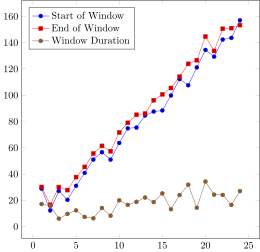

In [5]:
Axis([
    Plots.Linear(1:24, sdev_diff[1, :], legendentry="Start of Window")
    Plots.Linear(1:24, sdev_diff[2, :], legendentry="End of Window")
    Plots.Linear(1:24, sdev_diff[3, :], legendentry="Window Duration")
], width="10cm", height="10cm", legendPos="north west")